# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tools import add_constant
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
%matplotlib inline

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



### Data Exploration: Effect of Day of Week, Holidays, and Seasons


In [2]:
train_data = pd.read_csv('Bikeshare_train.csv')
test_data = pd.read_csv('Bikeshare_test.csv')

train_data = train_data.drop('Unnamed: 0', axis = 1)
test_data = test_data.drop('Unnamed: 0', axis = 1)

#weekend/weekday information
weekend_rental = sum(train_data[train_data.day_of_week == 0.0]['count']) + np.sum(train_data[train_data.day_of_week == 6.0]['count'])
weekday_rental = sum(train_data['count'])-weekend_rental
daily_rental = []
daily_label = ['Sun', 'Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat']
sunday = sum(train_data[train_data.day_of_week == 0.0]['count'])
daily_rental.append(sunday)
monday = sum(train_data[train_data.day_of_week == 1.0]['count'])
daily_rental.append(monday)
tuesday = sum(train_data[train_data.day_of_week == 2.0]['count'])
daily_rental.append(tuesday)
wednesday = sum(train_data[train_data.day_of_week == 3.0]['count'])
daily_rental.append(wednesday)
thursday = sum(train_data[train_data.day_of_week == 4.0]['count'])
daily_rental.append(thursday)
friday = sum(train_data[train_data.day_of_week == 5.0]['count'])
daily_rental.append(friday)
saturday = sum(train_data[train_data.day_of_week == 6.0]['count'])
daily_rental.append(saturday)

print("Number of weekend rentals: ", weekend_rental)
print("Number of weekday rentals: ", weekday_rental)
print("Average number of rentals per weekend day: ", weekend_rental / 2.0)
print("Average number of rentals per week day: ", weekday_rental / 5.0)
print()

#holiday/non-holiday information
holiday_rentals = sum(train_data[train_data.holiday == 1.0]['count'])
non_holiday_rentals = sum(train_data[train_data.holiday == 0.0]['count'])
holidays = len(train_data[train_data.holiday == 1.0])
print("Number of holiday rentals: ", holiday_rentals)
print("Number of non-holiday rentals: ", non_holiday_rentals)
print("Average number of rentals per holiday day: ", holiday_rentals/ holidays)
print("Average number of rentals per non-holiday day: ", non_holiday_rentals/(len(train_data)-holidays))
print()

#seasonal information
spring_rentals = sum(train_data[train_data.season == 1.0]['count'])
summer_rentals = sum(train_data[train_data.season == 2.0]['count'])
fall_rentals = sum(train_data[train_data.season == 3.0]['count'])
winter_rentals = sum(train_data[train_data.season == 4.0]['count'])
seasons = [spring_rentals, summer_rentals, fall_rentals, winter_rentals]
season_label = ['Spring', 'Summer', 'Fall', 'Winter']
print("Number of Spring rentals: ", spring_rentals)
print("Number of Summer rentals: ", summer_rentals)
print("Number of Fall rentals: ", fall_rentals)
print("Number of Winter rentals: ", winter_rentals)
print()

Number of weekend rentals:  440066.0
Number of weekday rentals:  1082020.0
Average number of rentals per weekend day:  220033.0
Average number of rentals per week day:  216404.0

Number of holiday rentals:  46191.0
Number of non-holiday rentals:  1475895.0
Average number of rentals per holiday day:  4199.18181818
Average number of rentals per non-holiday day:  4612.171875

Number of Spring rentals:  190060.0
Number of Summer rentals:  428774.0
Number of Fall rentals:  499905.0
Number of Winter rentals:  403347.0



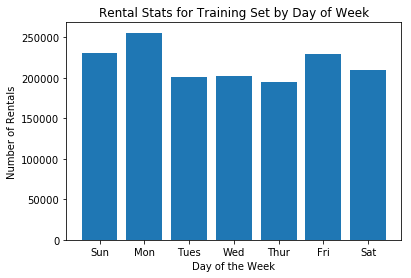

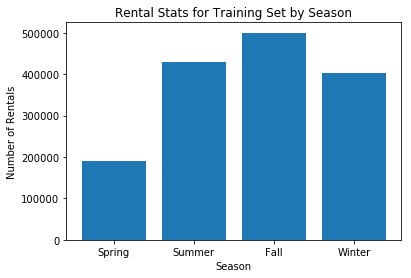

In [3]:
plt.figure(1)
plt.bar(range(1,8), daily_rental,tick_label=daily_label)
plt.xlabel("Day of the Week")
plt.ylabel("Number of Rentals")
plt.title("Rental Stats for Training Set by Day of Week")

plt.figure(2)
plt.bar(range(1,5), seasons, tick_label=season_label)
plt.xlabel("Season")
plt.ylabel("Number of Rentals")
plt.title("Rental Stats for Training Set by Season")


#### Analysis

#### How does the number of bike rentals vary between weekdays and weekends?

We can see in the printed statement above that there are slightly more rentals on average on a weekend day, but it is very close. Through the week, Monday is actually the day with the most total rentals. 

#### How about bike rentals on holidays?

Again, the counts of rentals on holidays and non-holidays are relatively close, but there are about 10% more rentals on non-holidays than on holidays, on average. This is a surprising result to me, because I would expect people to get out and rent bikes on holidays (i.e. long weekends are very popular for bike and kayak rentals in Cambridge). People biking to work must be a big factor behind this.

#### What effect does the season have on the bike rentals on a given day?

Seasonally, the bar chart shows us that Fall is a clear peak in bike rental, with Summer and Winter (both close) following in rentals, and finally, Spring is the least popular. This surprised me as well; I expected summer and spring to be the months with the most rentals.

### Data Exploration: Effect of Weather

In [4]:
#rain/snow information
rainy_snowy_days = train_data[(train_data['weather'] == 3.0) | (train_data['weather'] == 4.0)]
clear_days = train_data[(train_data['weather'] == 1.0) | (train_data['weather'] == 2.0)]
rainy_snowy_count = sum(rainy_snowy_days['count'])
clear_count = sum(clear_days['count'])
num_rainy = len(rainy_snowy_days)
num_clear = len(clear_days)
print("Number of clear day rentals: ", clear_count)
print("Number of rainy/snowy day rentals: ", rainy_snowy_count)
print("Average number of rentals per clear day: ", clear_count/num_clear)
print("Average number of rentals per rainy/snowy day: ", rainy_snowy_count/num_rainy)
print("Big difference there in the averages! Not surprising.")
print()

# temperature plot
indices = (train_data.temp != None) & (train_data.count != None) & (train_data.atemp != None)
temp_data = train_data[indices]['temp']
count_data = train_data[indices]['count']
atemp_data = train_data[indices]['atemp']

Number of clear day rentals:  1504724.0
Number of rainy/snowy day rentals:  17362.0
Average number of rentals per clear day:  4687.61370717
Average number of rentals per rainy/snowy day:  1736.2
Big difference there in the averages! Not surprising.



#### Analysis

#### Is the number of bike rentals lower than average when there is rain or snow?

Yes, much lower. On average, there are just over 1/3 as many rentals on rainy/snowy days as when it is clear or cloudy. This is an expected result, since biking in the rain isn't fun.

### Data Exploration: Effect of Temperature

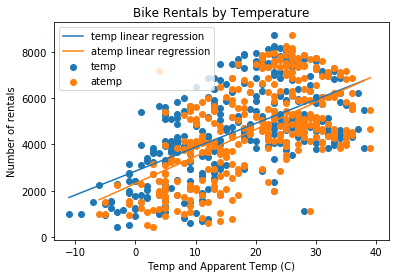

In [5]:
# add in line of best fit?
plt.figure(3)
plt.scatter(temp_data, count_data)
plt.scatter(atemp_data, count_data)
plt.plot(np.unique(temp_data), np.poly1d(np.polyfit(temp_data, count_data, 1))(np.unique(temp_data)))
plt.plot(np.unique(atemp_data), np.poly1d(np.polyfit(atemp_data, count_data, 1))(np.unique(atemp_data)))
plt.xlabel("Temp and Apparent Temp (C)")
plt.ylabel("Number of rentals")
plt.title("Bike Rentals by Temperature")
plt.legend(['temp linear regression', 'atemp linear regression', 'temp', 'atemp'])

#### Analysis

#### How does temperature effect bike rentals?

The scatter plot of temp vs rentals and atemp vs rentals (as well as the linear regressions fit to the data) show that although there is not a clear linear relationship, there are on average more rentals when it is warmer. This intuitively makes sense, because biking exposes you to air temperature and people would be less willing to bike in colder temperatures.

### Data Exploration: Non-Linear Dependencies

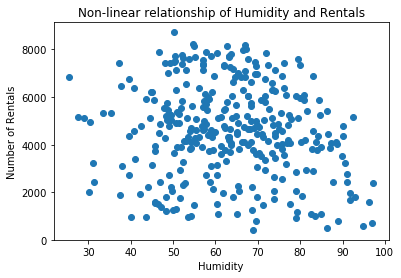

In [6]:
indices = (train_data.humidity != None) & (train_data.count != None)
plt.figure(4)
plt.scatter(train_data[indices]['humidity'], train_data[indices]['count'])
plt.xlabel("Humidity")
plt.ylabel("Number of Rentals")
plt.title("Non-linear relationship of Humidity and Rentals")

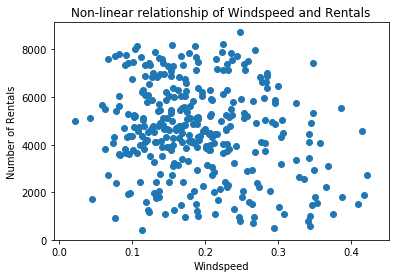

In [7]:
indices = (train_data.windspeed != None) & (train_data.count != None)
plt.figure(5)
plt.scatter(train_data[indices]['windspeed'], train_data[indices]['count'])
plt.xlabel("Windspeed")
plt.ylabel("Number of Rentals")
plt.title("Non-linear relationship of Windspeed and Rentals")

#### Analysis

#### Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?

The graph of humidity vs rentals shows that there is clearly no linear dependance between these variables. The scatter plot just looks like an arrangement of random points- there may be a relationship but it is definitely not linear. The same is true for the next plot of windspeed. Our conclusion from seeing these two relationships is that humidity and windspeed are usually not significant enough to affect a person's habits. As in, if they bike in humid weather, they will also probably bike in dry weather.


### Data Processing

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [8]:
train_data2 = pd.read_csv('Bikeshare_train.csv')
test_data2 = pd.read_csv('Bikeshare_test.csv')

train_data3 = pd.get_dummies(train_data2, columns = ['season', 'month', 'day_of_week', 'weather'])
test_data3 = pd.get_dummies(test_data2, columns = ['season', 'month', 'day_of_week', 'weather'])

print(train_data3.describe())
print(test_data3.describe())

       Unnamed: 0     holiday  workingday        temp       atemp    humidity  \
count  331.000000  331.000000  331.000000  331.000000  331.000000  331.000000   
mean   165.000000    0.033233    0.670695   17.018127   19.543807   63.385776   
std     95.695698    0.179515    0.470672   11.192515    9.930991   14.334789   
min      0.000000    0.000000    0.000000  -11.000000   -6.000000   25.416700   
25%     82.500000    0.000000    0.000000    7.500000   11.000000   52.702900   
50%    165.000000    0.000000    1.000000   18.000000   21.000000   63.291700   
75%    247.500000    0.000000    1.000000   26.000000   27.000000   73.500000   
max    330.000000    1.000000    1.000000   38.000000   39.000000   97.250000   

        windspeed        count  season_1.0  season_2.0     ...       \
count  331.000000   331.000000  331.000000  331.000000     ...        
mean     0.190833  4598.447130    0.217523    0.259819     ...        
std      0.078240  1935.319338    0.413186    0.439199   

In [9]:
# introduce binary columns for seasons, months, day_of_week, and weather
train_data = pd.get_dummies(train_data, columns = ['season', 'month', 'day_of_week', 'weather'])
test_data = pd.get_dummies(test_data, columns = ['season', 'month', 'day_of_week', 'weather'])

# drop kth column, already done for weather
train_data = train_data.drop('day_of_week_6.0', 1)
train_data = train_data.drop('season_4.0', 1)
train_data = train_data.drop('month_12.0', 1)
test_data = test_data.drop('day_of_week_6.0', 1)
test_data = test_data.drop('season_4.0', 1)
test_data = test_data.drop('month_12.0', 1)

# drop another weather column since the 4th column doesn't contain any data points
train_data = train_data.drop('weather_3.0', 1)
test_data = test_data.drop('weather_3.0', 1)

train_data.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1.0,season_2.0,season_3.0,...,month_10.0,month_11.0,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,weather_1.0,weather_2.0
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.033233,0.670695,17.018127,19.543807,63.385776,0.190833,4598.447130,0.217523,0.259819,0.265861,...,0.090634,0.093656,0.160121,0.175227,0.135952,0.123867,0.123867,0.145015,0.640483,0.329305
std,0.179515,0.470672,11.192515,9.930991,14.334789,0.078240,1935.319338,0.413186,0.439199,0.442459,...,0.287523,0.291790,0.367273,0.380736,0.343256,0.329929,0.329929,0.352649,0.480585,0.470672
min,0.000000,0.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.500000,11.000000,52.702900,0.133083,3370.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,26.000000,27.000000,73.500000,0.235380,5981.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,38.000000,39.000000,97.250000,0.421642,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1]:
# normalize
for i in ['temp', 'atemp', 'humidity', 'windspeed']:
    mean = train_data[i].mean()
    sd = train_data[i].std()
    train_data[i] = (train_data[i] - mean) / sd
    test_data[i] = (test_data[i] - mean) / sd

train_data.describe()
# we can see that mean is 1 and sd is 0 for temp, atemp, humidity, windspeed

NameError: name 'train_data' is not defined

#### Analysis

#### Why can't the categorical attributes be directly used as predictors?

Categorical variables can't be used as predictors because our regression will interpret the assigned values as actual numbers rather than as substitutes for categories. In general, we shouldn't be assigning an "order" to things that have no order. For instance, convention says that we start a year in the winter, but someone could easily argue that a year starts in spring, or even fall (like the school year). Another big issue is that it doesn't make sense to scale categorical variables with a coefficient, as this makes it difficult to interpret which of the variables are actually affecting the model. Instead, we introduce a binary system and apply to each possible category item to isolate the impact that category item is having.

#### Why is it okay to not have a binary column for the  KjKj -th category?

This is okay because each categorical type of variable has a value in one of the categories. So if we go through $j-1$ binary columns for a category with $j$ types, and have not seen a 1 yet, we can extrapolate that the jth column will be a 1, so it's unneccesary to use extra storage for redundant information.

#### Why shouldn't we include the test set observations in computing the mean and SD?

We shouldn't do this because if we touch the test set and perform calculations on it, then it invalidates our use of this data for testing. We have to leave the data alone if we want to use it later to test our fully organic model (not built using any test data).

#### Check for Null Values before Continuing

In [11]:
test_data.isnull().sum()

holiday            0
workingday         0
temp               0
atemp              0
humidity           0
windspeed          0
count              0
season_1.0         0
season_2.0         0
season_3.0         0
month_1.0          0
month_2.0          0
month_3.0          0
month_4.0          0
month_5.0          0
month_6.0          0
month_7.0          0
month_8.0          0
month_9.0          0
month_10.0         0
month_11.0         0
day_of_week_0.0    0
day_of_week_1.0    0
day_of_week_2.0    0
day_of_week_3.0    0
day_of_week_4.0    0
day_of_week_5.0    0
weather_1.0        0
weather_2.0        0
dtype: int64

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [12]:
# .loc[:, df_train.columns != 'count'].columns
X_train = train_data.loc[:, train_data.columns != 'count'].values
Y_train = train_data['count'].values

X_test = test_data.loc[:, test_data.columns != 'count'].values
Y_test = test_data['count'].values

multi_regr_model = LinearRegression(fit_intercept=True)
multi_regr_model.fit(X_train, Y_train)

test_R_sq = multi_regr_model.score(X_test, Y_test)
print("R^2 Value for Test Set: ", test_R_sq)

R^2 Value for Test Set:  0.249342111465


In [13]:
pred_names = train_data.loc[:, train_data.columns != 'count'].columns.values
pred_names_new = np.insert(pred_names, 0, 'constant')

# add a column of 1s
X = sm.add_constant(X_train)
regr_sm = sm.OLS(Y_train, X)
multi_regr_model = regr_sm.fit()
print(multi_regr_model.summary(xname=list(pred_names_new)))

X[0:len(X)][0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        20:48:37   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
constant         3672.2940    664.433     

array([ 1.        ,  0.        ,  1.        ,  0.6237984 ,  0.65010562,
        0.92066404, -0.92875796,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ])

### Analysis

Based on our preset significance level of 5%, we see that humidity, windspeed, the spring season, clear weather, and cloudy weather have statistically significant impacts on the number of bikes rented.

#### Which among the predictors have a positive correlation with the number of bike rentals? 

The temperature and apparent temperature have a positive correlation with the number of rentals. Of the indicator predictors, the months of January, February, March, April, May, September, October, and November, the day Wednesday, and clear and cloudy weather conditions also show positive correlations. Of all of these predictors, only the clear and cloudy weather conditions have an impact on the count of rentals that is statistically significant (p < 0.05). The temperature also comes close with a p-value of 0.052.

#### Does the day of a week have a relationship with bike rentals? 

No; none of the days we tested have a p-value < 0.05, meaning none contribute to the rental count in a statistically significant way. In other words, the variation between the days can be explained by randomness.

#### Does the month influence the bike rentals? 

No; just like the days of the week, none of the months we tested had a p-value < 0.05. Once again, the month does not affect the number of rentals in a statistically significant way, and the variation can be explained by randomness.

#### What effect does a holiday have on bike rentals? 

The coefficient is negative, meaning that less people rent bikes if the day is a holiday. This makes sense because people don't need to go to work on holidays, and are in general more likely to stay home. However, this effect is not statistically significant since the p-value is not < 0.05, which means the negative correlation could be explained by randomness.

#### Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.

Yes, there is a difference of over 600. We attribute this difference to the fact that `temp` and `atemp` are probably nearly collinear, and whatever could be explained by `temp` could also be explained by `atemp`. Thus, the model simply selects which one happens to be more accurate at each particular point. It does make sense that these coefficients have the same sign however, since `temp` and `atemp` themselves are positively correlated.


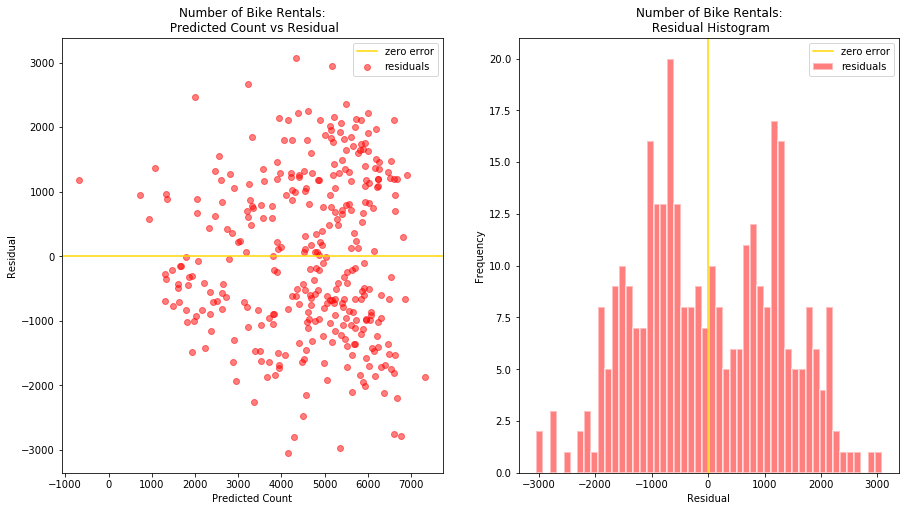

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
# add a column of 1s, add_constant
errors = Y_train - multi_regr_model.predict(X)
ax[0].scatter(multi_regr_model.predict(X), errors, color='r', alpha=0.5, label='residuals')
ax[0].axhline(y=0, color='gold', label='zero error')

ax[0].set_xlabel('Predicted Count')
ax[0].set_ylabel('Residual')
ax[0].set_title('Number of Bike Rentals:\n Predicted Count vs Residual')
ax[0].legend(loc='best')

ax[1].hist(errors, color='r', alpha=0.5, label='residuals', bins=50, edgecolor='white', linewidth=2)
ax[1].axvline(x=0, color='gold', label='zero error')

ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Number of Bike Rentals:\n Residual Histogram')
ax[1].legend(loc='best')

### Analysis

#### Does the plot reveal a non-linear relationship between the predictors and response? 

No; the residuals look evenly distributed above the zero error line, which suggests that our linear model is an accurate one. 

#### What does the plot convey about the variance of the error terms?

The even distribution of residuals conveys that the variance is random.


## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

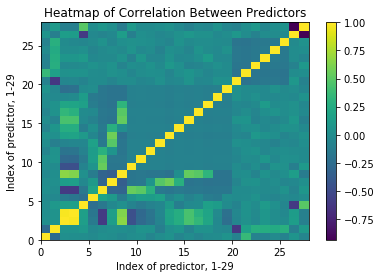

In [15]:
# extract dataframe with all predictors
corr_df = train_data.loc[:, train_data.columns != 'count']

trans = corr_df.values.T
coeff_matrix1 = np.corrcoef(trans)

plt.figure(1)
heatmap = plt.pcolor(coeff_matrix1)
plt.title("Heatmap of Correlation Between Predictors")
plt.xlabel("Index of predictor, 1-29")
plt.ylabel("Index of predictor, 1-29")
plt.colorbar(heatmap)

#### Does the data suffer from multi-collinearity? 

ANSWER: Yes, there are a few sets of predictors with a high value of correlation. 

3,4
9,3
9,4
28,5
7,10
7,11
8,13
8,14
9,16
9,17

#### Are there predictors that fall into natural groups based on the correlation values?

ANSWER: Months with Seasons. Atemp and Temp
 

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [16]:
# STEP-WISE FORWARD SELECTION of PREDICTORS using BIC
def forward_select(x, y): # x is dataframe, y is counts
    # Makes use of code for exhaustive selection from section notes
    # ms stores the best model for #predictors=0,1,2...
    ms = [[]]
    
    # store bic values for testing purposes
    bics = [100000000]
    d = x.shape[1]

    # find best set of predictors for each value up to #predictors
    for k in range(1,d):
        min_bic = 10000
        min_temp_model = []
        model = ms[k-1]
        
        # get predictors that are not in temp_model
        remaining_predictors = np.setdiff1d(predictors,model)
        
        # for each predictor, add to model, fit regression, 
        # see if it is a new min BIC value
        for pred in remaining_predictors:
            temp_model = copy.deepcopy(model)
            # add new predictor to model and fit
            temp_model.append(pred)
            x_subset = sm.add_constant(x[list(temp_model)])
            model_regression = OLS(y, x_subset)
            results = model_regression.fit()
            # store this model as the new minimum if < min_bic
            bic = results.bic
            if bic < min_bic:
                min_bic = bic
                min_temp_model = temp_model
        # bics and ms now hold information for the best model with k predictors
        bics.append(min_bic)
        ms.append(min_temp_model)
        
    # iterate through models of different sizes, pick lowest BIC
    overall_min_bic = 10000
    overall_min_model = ms[0]
    for m in ms:
        if m != []:
            # fit OLS model for each set of predictors
            x_subset = add_constant(x[m])
            model = OLS(y, x_subset)
            results = model.fit()
            bic = results.bic
            if bic < overall_min_bic:
                overall_min_bic = bic
                overall_min_model = m
    
    # returns list of predictors corresponding to best model        
    return overall_min_model

In [17]:
def backward_select(x, y): # x is dataframe (columns predictors), y is counts
    # Makes use of code for exhaustive selection from section notes
    d = x.shape[1]
    # ms holds the best model with #predictors = 28, 27, ..., 1
    ms = [predictors]

    # find best set of predictors for each value up to #predictors
    for k in range(1,d):
        min_bic = 10000
        min_temp_model = []
        model = ms[k-1]
        if len(model) > 1:
        
            # get predictors that are not in temp_model
            for index, pred in enumerate(model):
                temp_model = copy.deepcopy(model)
                # remove one predictor from previous model on each iteration
                temp_model.pop(index)
                # fit OLS model
                x_subset = sm.add_constant(x[list(temp_model)])
                model_regression = OLS(y, x_subset)
                results = model_regression.fit()
                # store this model as the new minimum if < min_bic
                bic = results.bic
                if bic < min_bic:
                    min_bic = bic
                    min_temp_model = temp_model
            ms.append(min_temp_model)
        
    # iterate through models of different sizes, pick lowest BIC
    overall_min_bic = 10000
    overall_min_model = ms[0]
    for m in ms:
        if m != []:
            # fit the model and determine the minimum
            x_subset = add_constant(x[m])
            model = OLS(y, x_subset)
            results = model.fit()
            bic = results.bic
            if bic < overall_min_bic:
                overall_min_bic = bic
                overall_min_model = m
    
    # returns list of predictors corresponding to best model        
    return overall_min_model

In [25]:

import copy

predictors = list(pred_names)

# call function to get the best set of predictors using forward selection
best_forward_model = forward_select(train_data[predictors], train_data['count'])
print("Predictors selected from forward selection: ", best_forward_model)

# prepare data for modeling
x_subset = add_constant(train_data[best_forward_model])
y = train_data['count']

# fit the model
est = LinearRegression()
est.fit(x_subset, y) # fit
prediction = est.predict(x_subset)
test_prediction = est.predict(add_constant(test_data[best_forward_model]))

# generate and print train r2, test r2, and train BIC
forward_r2 = r2_score(y, prediction)
forward_test_r2 = r2_score(test_data['count'], test_prediction)
model = OLS(y, x_subset)
results = model.fit()
forward_bic = results.bic
print("R2 Value for Best Forward Selection Model: ", forward_r2)
print("R2 TEST Value for Best Forward Selection Model: ", forward_test_r2)
print("BIC Value for Best Forward Selection Model: ", forward_bic)
print()


# call function to get the best set of predictors using backward selection
best_backward_model = backward_select(train_data[predictors], train_data['count'])
print("Predictors selected from backward selection: ", best_backward_model)

# prepare data for modeling
x_subset = add_constant(train_data[best_backward_model])
y = train_data['count']

# fit the model
est = LinearRegression()
est.fit(x_subset, y) # fit
prediction = est.predict(x_subset)
test_prediction = est.predict(add_constant(test_data[best_backward_model]))

# generate and print train r2, test r2, and train BIC
backward_test_r2 = r2_score(test_data['count'], test_prediction)
backward_r2 = r2_score(y, prediction)
model = OLS(y, x_subset)
results = model.fit()
backward_bic = results.bic
print("R2 Value for Best Backward Selection Model: ", backward_r2)
print("R2 TEST Value for Best Backward Selection Model: ", backward_test_r2)
print("BIC Value for Best Backward Selection Model: ", backward_bic)
print()


Predictors selected from forward selection:  ['atemp', 'humidity', 'season_1.0', 'month_9.0', 'month_10.0', 'windspeed', 'month_7.0']
R2 Value for Best Forward Selection Model:  0.534328867236
R2 TEST Value for Best Forward Selection Model:  0.233907286063
BIC Value for Best Forward Selection Model:  5741.81180016

Predictors selected from backward selection:  ['temp', 'humidity', 'windspeed', 'season_1.0', 'month_6.0', 'month_7.0', 'month_8.0']
R2 Value for Best Backward Selection Model:  0.535287352653
R2 TEST Value for Best Backward Selection Model:  0.235806759622
BIC Value for Best Backward Selection Model:  5741.12980464



#### Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? 

ANSWER: Yes, these methods do eliminate redundant predictors. As we can see, both forward and backward selection reduce our 28 original predictors into only 7 predictors. As a result, several redundancies that we noticed in part C were eliminated. Temp and Atemp are highly correlated, so each model only picks one, and drops the other (forward selects atemp, backward selects temp). Additionally, we see that there is no overlap in month and season data. Forward selection uses season 1.0 (Spring), as well as months 7.0, 9.0, and 10.0 (July, September, and October), so there is no redundancy between season and month data. Backward selection uses season 1.0 (Spring), as well as months 6.0, 7.0, and 8.0 (June, July, and August), so again, there is no redundancy between season and month data. Of course, many of the other predictors that are removed are likely correlated with predictors that remain, so other redundanies are likely eliminated. 

#### How do the test  R2R2 scores for the fitted models compare with the model fitted in Part (b) using all predictors?

The test R2 scores are slightly lower than the model fit in b) with all predictors. All predictors yields r2 = .576, and here, forward selection yields r2 = .534, and backward selection yields r2 = .535. These r2 values are generated from the training data, so it makes sense that all variables will fit the data better, since more predictors can more closely model the trends, even though this may overfit for the test data. As we can see, test r2 values for forward and backward selection is much lower than the training values, and this is likely the case for all predictors too. The reason why forward and backward selection pick models with lower r2 values than all predictors is that BIC punishes excessive use of predictors, and tries to maximize fit with a minimal amount of predictors. 

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

train_errors = np.zeros((3,10))
valid_errors = np.zeros((3,10))
train_R_sqs = np.zeros((3,10))
valid_R_sqs = np.zeros((3,10))

predictors = list(pred_names)

# collect 3 sets of predictors used
forward_predictors = forward_select(train_data[list(predictors)], train_data['count'])
backward_predictors = backward_select(train_data[list(predictors)], train_data['count'])
all_predictors = predictors
predictor_set = [forward_predictors, backward_predictors, all_predictors]

n_folds = 10

for index, preds in enumerate(predictor_set):
    fold = 0
    for train, valid in KFold(n_folds, shuffle=True).split(range(331)): # split data into train/test groups, 4 times
        X_train = add_constant(train_data[preds])
        Y_train = train_data['count']
        est = LinearRegression()
        est.fit(X_train.ix[train], Y_train.ix[train]) # fit
        train_errors[index,fold] = (mean_squared_error(Y_train.ix[train], est.predict(X_train.ix[train]))) # evaluate score function on held-out data
        valid_errors[index,fold] = (mean_squared_error(Y_train.ix[valid], est.predict(X_train.ix[valid]))) # evaluate score function on held-out data
        train_R_sqs[index,fold] = (est.score(X_train.ix[train], Y_train.ix[train]))
        valid_R_sqs[index,fold] = (est.score(X_train.ix[valid], Y_train.ix[valid]))
        fold += 1
        
print()
print("TRAIN ERRORS: ")
print(train_errors)
print()
print("VALIDATION ERRORS: ")
print(valid_errors)
print()
print("TRAIN R SQUARED: ")
print(train_R_sqs)
print()
print("VALIDATION R SQUARED: ")
print(valid_R_sqs)
print()
print("AVERAGE R SQUARED FOR VALIDATION SETS w/ FORWARD SELECTION: ", np.mean(valid_R_sqs[0]))
print("AVERAGE R SQUARED FOR VALIDATION SETS w/ BACKWARD SELECTION: ", np.mean(valid_R_sqs[1]))
print("AVERAGE R SQUARED FOR VALIDATION SETS w/ ALL PREDICTORS: ", np.mean(valid_R_sqs[2]))
    
r_sqs = []
for preds in predictor_set:
    try:
        X_train = add_constant(train_data[preds])
        Y_train = train_data['count']
        est = LinearRegression(fit_intercept = True)
        est.fit(X_train, Y_train) # fit
        test_R_sq = est.score(add_constant(test_data[preds]), test_data['count'])
        r_sqs.append(test_R_sq)
    except: print(preds)

print()
print("R SQUARED VALUE FOR TEST SET WITH FORWARD SELECTION: ", r_sqs[0])
print("R SQUARED VALUE FOR TEST SET WITH BACKWARD SELECTION: ", r_sqs[1])
print("R SQUARED VALUE FOR TEST SET WITH ALL PREDICTORS: ", r_sqs[2])


TRAIN ERRORS: 
[[ 1663996.29849652  1747767.35610558  1782836.5749766   1785726.88254717
   1808653.22553773  1633752.45887987  1708157.26347206  1776037.07581112
   1751129.3923874   1686988.01153565]
 [ 1732581.89659374  1654985.82256329  1722027.54172804  1717774.21096662
   1668717.32992638  1729838.96482046  1733294.048434    1765751.20165229
   1796130.50053751  1770093.51868193]
 [ 1617958.14977652  1471015.14399125  1635528.79249385  1566709.12877065
   1570373.56639446  1589212.20332479  1597389.82075366  1558865.14826652
   1490101.18169903  1528000.96976774]]

VALIDATION ERRORS: 
[[ 2471877.67455734  1712428.87952247  1387455.44494581  1351741.10947965
   1118493.27508892  2752560.54990321  2055782.95397716  1413434.41959436
   1678750.08194913  2263181.82311875]
 [ 1815727.30720741  2556734.48973598  1920836.14853711  1968806.58238529
   2419105.01430425  1867817.67020394  1824985.67494782  1475355.2831534
   1219274.82588968  1479265.94613209]
 [ 1421588.05567237  4690673



#### Report the average $R^2$ across all 10 validation sets for each model and compare the results. Why do you think this is the case?

There appears to be a minimal difference between the $R^2$ values when we forward selection vs. backward selection. However, both of these $R^2$ values are higher than the $R^2$ value for the set with all predictors. This difference makes sense because we have improved the model by selecting certain predictors.

#### Evaluate each of the 3 models on the provided left out test set by calculating $R^2$. Do the results agree with the cross-validation? Why or why not?

These results do 